# Preparation

## Environment Setup

In [ ]:
!pip install -r requirements.txt

In [1]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 6.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

## Selection of Hyperparameters

Based on paper, we select the optimized hyperparameters

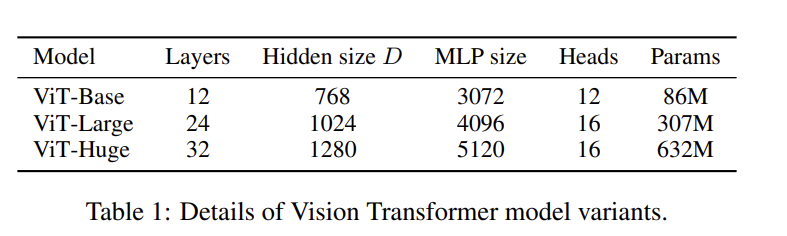

From paper, AN IMAGE IS WORTH 16X16 WORDS:
TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE.
Vit-Base has hidden size around 768.
But it is computationally heavy for our project.
So we decided to use Vit-T (Vit-Tiny)
It has embedding-dim of 256.

In [2]:
# Hyperparameters for VIT-tiny
# embedding_dim is bigger for VIT-Base
class Hyperparams:
    img_dim = 32  # Image dimension
    patch_size = 2  # Size of each patch
    embedding_dim = 256  # Embedding dimensionality of the model (Decoder width)

    encoder_depth = 12  # Number of blocks in the encoder
    encoder_heads = 4  # Number of attention heads in each encoder block
    decoder_depth = 4  # Optimal number of blocks in the decoder for linear probing
    decoder_heads = 4  # Number of attention heads in each decoder block
    mask_ratio = 0.75  # Optimal masking ratio

## How We Implement Shuffling & Unshuffling

In [3]:
import torch

# Original tensor
data = torch.tensor([10, 20, 30, 40, 50])

# Forward indices for shuffling
fwd_indices = torch.tensor([2, 0, 4, 1, 3])

# Applying forward indices
shuffled = data[fwd_indices]

# Reverse indices to restore original order
rev_indices = torch.argsort(fwd_indices)

# Restoring original order
restored = shuffled[rev_indices]

print("Original:", data)
print("Shuffled:", shuffled)
print("Restored:", restored)


Original: tensor([10, 20, 30, 40, 50])
Shuffled: tensor([30, 10, 50, 20, 40])
Restored: tensor([10, 20, 30, 40, 50])


# Building MAE Pre-Training Pipeline

## (Helper Functions)

In [4]:
import numpy as np
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor, Normalize, Compose
from timm.models.vision_transformer import Block
from timm.models.layers import trunc_normal_


# Initialize module weights
def initialize_weights(module):
    """Apply custom weight initialization for different module types."""
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)
    elif isinstance(module, nn.LayerNorm):
        nn.init.constant_(module.bias, 0)
        nn.init.constant_(module.weight, 1.0)
    elif hasattr(module, 'mask_token'):
        trunc_normal_(module.mask_token, std=.01)
    elif hasattr(module, 'position_encodings'):
        trunc_normal_(module.position_encodings, std=.01)


# Generate random indices for shuffling
def generate_random_indices(length: int):
    indices = np.random.permutation(length)
    reverse_indices = np.argsort(indices)
    return torch.from_numpy(indices), torch.from_numpy(reverse_indices)

# Indexing operation for tensors
def index_tensor(tensor, indices):
    indices = indices.to(tensor.device).long()
    expanded_indices = indices.unsqueeze(-1).expand(-1, -1, tensor.shape[-1])
    return torch.gather(tensor, 0, expanded_indices)

def reshape_and_permute(image, patch_size, image_size):
    """Reshape and permute the image tensor for processing."""
    grid_height, grid_width = image_size // patch_size, image_size // patch_size
    image = image.view(grid_height, grid_width, -1, 3, patch_size, patch_size)
    image = image.permute(2, 3, 0, 4, 1, 5)
    image = image.reshape(-1, 3, grid_height * patch_size, grid_width * patch_size)
    return image

## Patchify & Masking Layer

In [5]:
class PatchShuffle(nn.Module):
    """Shuffles patches of an image by a specified ratio."""
    def __init__(self, ratio):
        super().__init__()
        self.ratio = ratio
        self.patch_size = Hyperparams.patch_size
        self.image_size = Hyperparams.img_dim
    def forward(self, patches):
        total_patches, batch_size, embedding_dim = patches.shape
        num_shuffle = int(total_patches * self.ratio)
        remaining_patches = total_patches - num_shuffle
        random_indices = [generate_random_indices(total_patches) for _ in range(batch_size)]
        forward_indices = torch.stack([idx[0] for idx in random_indices], axis=-1).to(patches.device)
        restoration_indices = torch.stack([idx[1] for idx in random_indices], axis=-1).to(patches.device)
        selected_patches = index_tensor(patches, forward_indices)[:remaining_patches]
        expanded_restoration_indices = torch.cat([torch.zeros(1, restoration_indices.shape[1]).to(restoration_indices), restoration_indices + 1], dim=0)
        image_mask = torch.ones((total_patches, batch_size,3 * Hyperparams.patch_size ** 2))
        image_mask[:remaining_patches] = 0
        mask_after_indexing = index_tensor(image_mask, expanded_restoration_indices[1:] - 1)
        mask = reshape_and_permute(mask_after_indexing, self.patch_size, self.image_size)
        return selected_patches, mask, restoration_indices

## ViT Encoder (Image -> Embedded Patches)



In [6]:
class VisionEncoder(nn.Module):
    """Encodes an image into a set of features using a vision transformer."""
    def __init__(self):
        super().__init__()
        self.pos_embeddings = nn.Parameter(torch.zeros((Hyperparams.img_dim // Hyperparams.patch_size) ** 2, 1, Hyperparams.embedding_dim))
        self.patch_to_embedding = nn.Conv2d(3, Hyperparams.embedding_dim, Hyperparams.patch_size, Hyperparams.patch_size)
        self.final_layer_norm = nn.LayerNorm(Hyperparams.embedding_dim)
        self.transformer_blocks = nn.Sequential(*[Block(Hyperparams.embedding_dim, Hyperparams.encoder_heads) for _ in range(Hyperparams.encoder_depth)])
        self.shuffle = PatchShuffle(Hyperparams.mask_ratio)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, Hyperparams.embedding_dim))
        self.apply(initialize_weights)

    def forward(self, image):
        patches = self.patch_to_embedding(image)
        batch_size, embedding_dim, height, width = patches.size()
        patches = patches.view(batch_size, embedding_dim, height * width).permute(2, 0, 1)
        patches += self.pos_embeddings
        shuffled_patches, mask, restoration_indices = self.shuffle(patches)
        patches_with_cls = torch.cat([self.cls_token.expand(-1, shuffled_patches.shape[1], -1), shuffled_patches], dim=0)
        patches_with_cls = patches_with_cls.permute(1, 0, 2)
        features = self.final_layer_norm(self.transformer_blocks(patches_with_cls)).permute(1, 0, 2)
        return features, mask, restoration_indices

## ViT Decoder (Embedded Patches -> Reconstructed Image)

In [7]:
class VisionDecoder(nn.Module):
    """Decodes the features back into an image using a reverse process of the encoder."""
    def __init__(self):
        super().__init__()
        self.pos_embeddings = nn.Parameter(torch.zeros((Hyperparams.img_dim // Hyperparams.patch_size) ** 2 + 1, 1, Hyperparams.embedding_dim))
        self.to_patches = nn.Linear(Hyperparams.embedding_dim, 3 * Hyperparams.patch_size ** 2)
        self.patch_size = Hyperparams.patch_size
        self.image_size = Hyperparams.img_dim
        self.mask_token = nn.Parameter(torch.zeros(1, 1, Hyperparams.embedding_dim))
        self.transformer_blocks = nn.Sequential(*[Block(Hyperparams.embedding_dim, Hyperparams.decoder_heads) for _ in range(Hyperparams.decoder_depth)])
        self.apply(initialize_weights)

    def forward(self, features, restoration_indices):
        num_positions = features.shape[0]
        expanded_restoration_indices = torch.cat([torch.zeros(1, restoration_indices.shape[1]).to(restoration_indices), restoration_indices + 1], dim=0)
        expanded_features = torch.cat([features, self.mask_token.expand(expanded_restoration_indices.shape[0] - features.shape[0], features.shape[1], -1)], dim=0)
        reordered_features = index_tensor(expanded_features, expanded_restoration_indices) + self.pos_embeddings
        transformed_features = self.transformer_blocks(reordered_features.permute(1, 0, 2)).permute(1, 0, 2)[1:]
        patches = self.to_patches(transformed_features)
        image = reshape_and_permute(patches, self.patch_size, self.image_size)
        return image

## MAE Pre-Training Pipeline (Image -> Encoder + Decoder -> Reconstructed Image)

In [8]:
class MAEModel(nn.Module):
    """Combines the encoder and decoder into a full Masked Autoencoder model."""
    def __init__(self):
        super().__init__()
        self.encoder = VisionEncoder()
        self.decoder = VisionDecoder()
        self.apply(initialize_weights)

    def forward(self, image):
        features, mask, restoration_indices = self.encoder(image)
        reconstructed_image = self.decoder(features, restoration_indices)
        return reconstructed_image, mask


## (Example Execution)

In [9]:
# Example execution
if __name__ == "__main__":
    example_img = torch.rand(5, 3, 32, 32)
    mae_model = MAEModel()
    predicted_image, mask = mae_model(example_img)
    print(predicted_image.shape)
    reconstruction_loss = torch.mean((predicted_image - example_img) ** 2 * mask / 0.75)
    print(reconstruction_loss)

torch.Size([5, 3, 32, 32])
tensor(7.8375, grad_fn=<MeanBackward0>)



# Visualization of Patchify & Masking

## Patchify an Image

100%|██████████| 170498071/170498071 [00:04<00:00, 37242931.30it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Index selected: 0


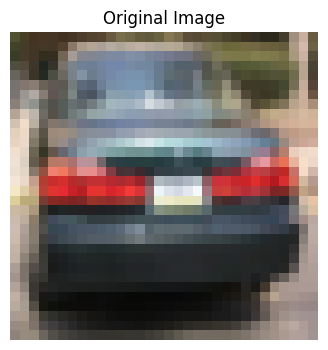

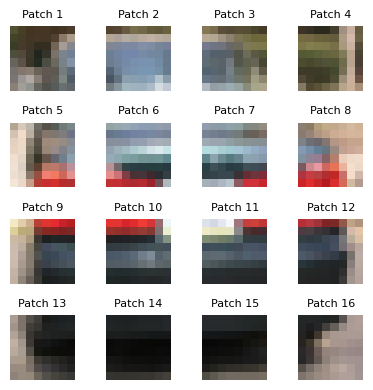

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

class PatchVisualizer:
    def __init__(self, patch_size):
        self.patch_size = patch_size

    def extract_patches(self, images, patch_size):
        # Extract patches using unfold
        patches = images.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
        patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous()
        patches = patches.view(images.size(0), -1, 3, patch_size, patch_size)
        return patches

    def show_patched_image(self, images, patches):
        idx = np.random.randint(0, images.size(0))
        print(f"Index selected: {idx}")

        img = images[idx].permute(1, 2, 0).detach().numpy()
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.axis("off")
        plt.title("Original Image")
        plt.show()

        n = int(np.sqrt(patches.size(1)))
        fig, axs = plt.subplots(n, n, figsize=(n , n))
        for i in range(n):
            for j in range(n):
                patch_idx = i * n + j
                patch_img = patches[idx, patch_idx].permute(1, 2, 0).detach().numpy()
                axs[i, j].imshow(patch_img)
                axs[i, j].axis('off')
                axs[i, j].set_title(f'Patch {i*n+j+1}', fontsize=8)  # Adding a title to each patch
        plt.tight_layout()
        plt.show()

def load_cifar10(batch_size=1):
    # CIFAR-10 dataset loading
    transform = transforms.Compose([
        transforms.ToTensor()  # Transform images to PyTorch tensors
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    return trainloader

# Load CIFAR-10 images
trainloader = load_cifar10()
images, _ = next(iter(trainloader))  # Get a batch of images

# Initialize the visualizer with the desired patch size
patch_size = 8
visualizer = PatchVisualizer(patch_size)

# Extract patches from images
patches = visualizer.extract_patches(images, patch_size)

# Display an image and its patches
visualizer.show_patched_image(images, patches)


## Masking X% of the Patches

Files already downloaded and verified


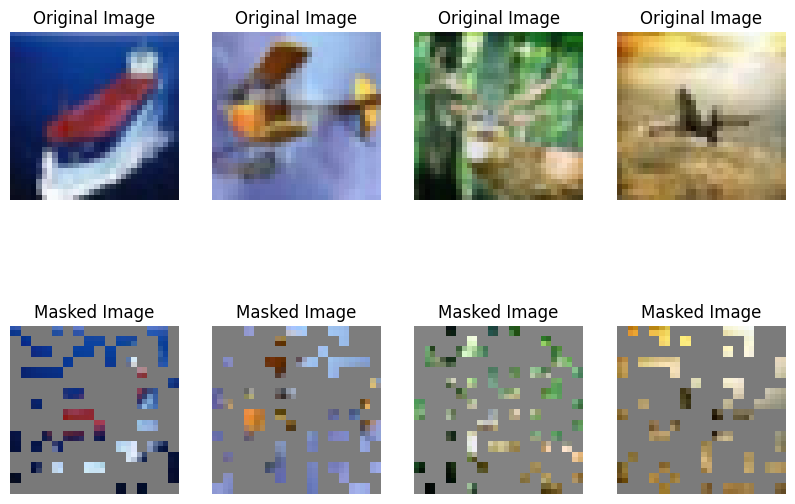

In [11]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
import matplotlib.pyplot as plt



def visualize_masking_and_reconstruction():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = Compose([ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

    images, _ = next(iter(loader))
    images = images.to(device)

    # Initialize the MAE model
    model = MAEModel().to(device)

    # Forward pass through the model to get the reconstructed image and mask
    with torch.no_grad():
        model.eval()
        predicted_img, mask = model(images)

    # Normalize function for visualization
    def normalize(img):
        img = img - img.min()
        img = img / (img.max() + 1e-5)
        return img

    # Prepare original and reconstructed images for visualization
    images_np = images.cpu().detach().permute(0, 2, 3, 1).numpy()
    # Prepare masked images by applying the mask correctly
    mask_np = mask.cpu().detach().permute(0, 2, 3, 1).numpy()
    masked_images_np = images_np * (1- mask_np)

    fig, axs = plt.subplots(2, 4, figsize=(10, 7))
    for i in range(4):
        axs[0, i].imshow(normalize(images_np[i]))
        axs[0, i].set_title('Original Image')
        axs[0, i].axis('off')

        axs[1, i].imshow(normalize(masked_images_np[i]))
        axs[1, i].set_title('Masked Image')
        axs[1, i].axis('off')

    plt.show()

if __name__ == '__main__':
    visualize_masking_and_reconstruction()


# Pre-Training the MAE Encoder


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pre-Training Details (Follow the Paper)

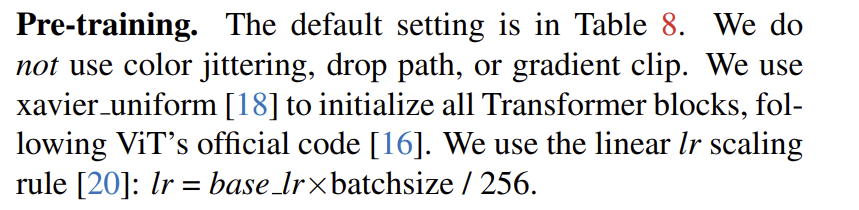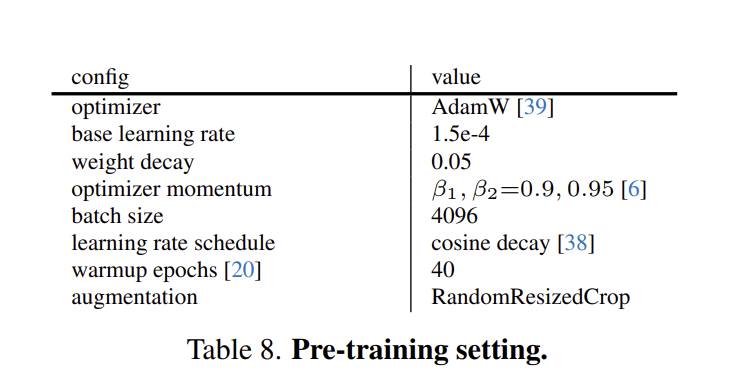

## Trained for 10 epochs


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/196 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 196/196 [01:08<00:00,  2.86it/s]


Epoch 1, Train Loss: 0.2804, Validation Loss: 0.1232


100%|██████████| 196/196 [01:08<00:00,  2.88it/s]


Epoch 2, Train Loss: 0.1191, Validation Loss: 0.1140


100%|██████████| 196/196 [01:08<00:00,  2.86it/s]


Epoch 3, Train Loss: 0.1040, Validation Loss: 0.1004


100%|██████████| 196/196 [01:08<00:00,  2.87it/s]


Epoch 4, Train Loss: 0.0971, Validation Loss: 0.0982


100%|██████████| 196/196 [01:09<00:00,  2.83it/s]


Epoch 5, Train Loss: 0.0927, Validation Loss: 0.0890


100%|██████████| 196/196 [01:08<00:00,  2.87it/s]


Epoch 6, Train Loss: 0.0846, Validation Loss: 0.0820


100%|██████████| 196/196 [01:07<00:00,  2.88it/s]


Epoch 7, Train Loss: 0.0807, Validation Loss: 0.0787


100%|██████████| 196/196 [01:08<00:00,  2.87it/s]


Epoch 8, Train Loss: 0.0734, Validation Loss: 0.0695


100%|██████████| 196/196 [01:08<00:00,  2.86it/s]


Epoch 9, Train Loss: 0.0628, Validation Loss: 0.0558


100%|██████████| 196/196 [01:08<00:00,  2.85it/s]


Epoch 10, Train Loss: 0.0499, Validation Loss: 0.0431
Loss data saved to /content/drive/My Drive/Colab_Models/loss_data_10.csv
Model saved to /content/drive/My Drive/Colab_Models/mae_pretrained_10.pth


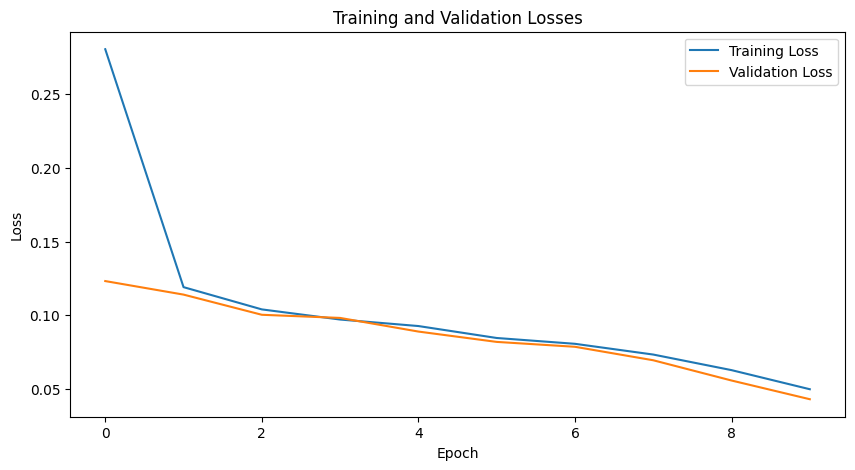

In [22]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize, RandomResizedCrop
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import csv  # Import csv module
from google.colab import drive
drive.mount('/content/drive')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def set_seed(seed=42):
    """Set seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Dataset and DataLoader setup
def get_transforms():
    return Compose([
        RandomResizedCrop(32),  # Data augmentation
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize for CIFAR10
    ])

def get_dataloaders(batch_size):
    train_dataset = CIFAR10(root='/content/data', train=True, download=True, transform=get_transforms())
    val_dataset = CIFAR10(root='/content/data', train=False, download=True, transform=get_transforms())
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    return train_loader, val_loader

batch_size = 256
train_loader, val_loader = get_dataloaders(batch_size)

# Initialize the model, optimizer, and loss criterion
model = MAEModel().to(device)  # Ensure MAEModel is defined elsewhere in your script

# Initialize transformer blocks with Xavier uniform
def initialize_model(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

initialize_model(model)

# Adjusted learning rate according to the linear scaling rule
base_lr = 1.5e-4 * (batch_size / 256)
optimizer = optim.AdamW(model.parameters(), lr=base_lr, betas=(0.9, 0.95), weight_decay=0.05)
criterion = nn.MSELoss()

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0)  # Cosine decay

# Lists to hold loss data for plotting
train_losses = []
val_losses = []

# Training and validation functions
def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    for images, _ in tqdm(dataloader):
        images = images.to(device)
        optimizer.zero_grad()
        reconstructed_images, mask = model(images)
        mask = mask.to(device)
        loss = criterion(reconstructed_images * mask, images * mask)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler.step()  # Update the learning rate
    return total_loss / len(dataloader)



def validate(model, dataloader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            reconstructed_images, mask = model(images)
            mask = mask.to(device)
            loss = criterion(reconstructed_images * mask, images * mask)
            total_loss += loss.item()
    return total_loss / len(dataloader)
num_epochs = 10
# Training loop
for epoch in range(num_epochs):
    if epoch < 40:  # Warmup epochs
        scheduler.base_lrs = [base_lr * (epoch + 1) / 40 for _ in optimizer.param_groups]
    train_loss = train_one_epoch(model, train_loader, optimizer, device)
    val_loss = validate(model, val_loader, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')


folder_path = '/content/drive/My Drive/Colab_Models'
# Save the loss data to a CSV file
loss_data_path = os.path.join(folder_path, 'loss_data_10.csv')
with open(loss_data_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Epoch', 'Train Loss', 'Validation Loss'])
    for i, (t_loss, v_loss) in enumerate(zip(train_losses, val_losses)):
        writer.writerow([i + 1, t_loss, v_loss])

print(f"Loss data saved to {loss_data_path}")

# Save the model's state
os.makedirs(folder_path, exist_ok=True)
model_save_path = os.path.join(folder_path, 'mae_pretrained_10.pth')
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


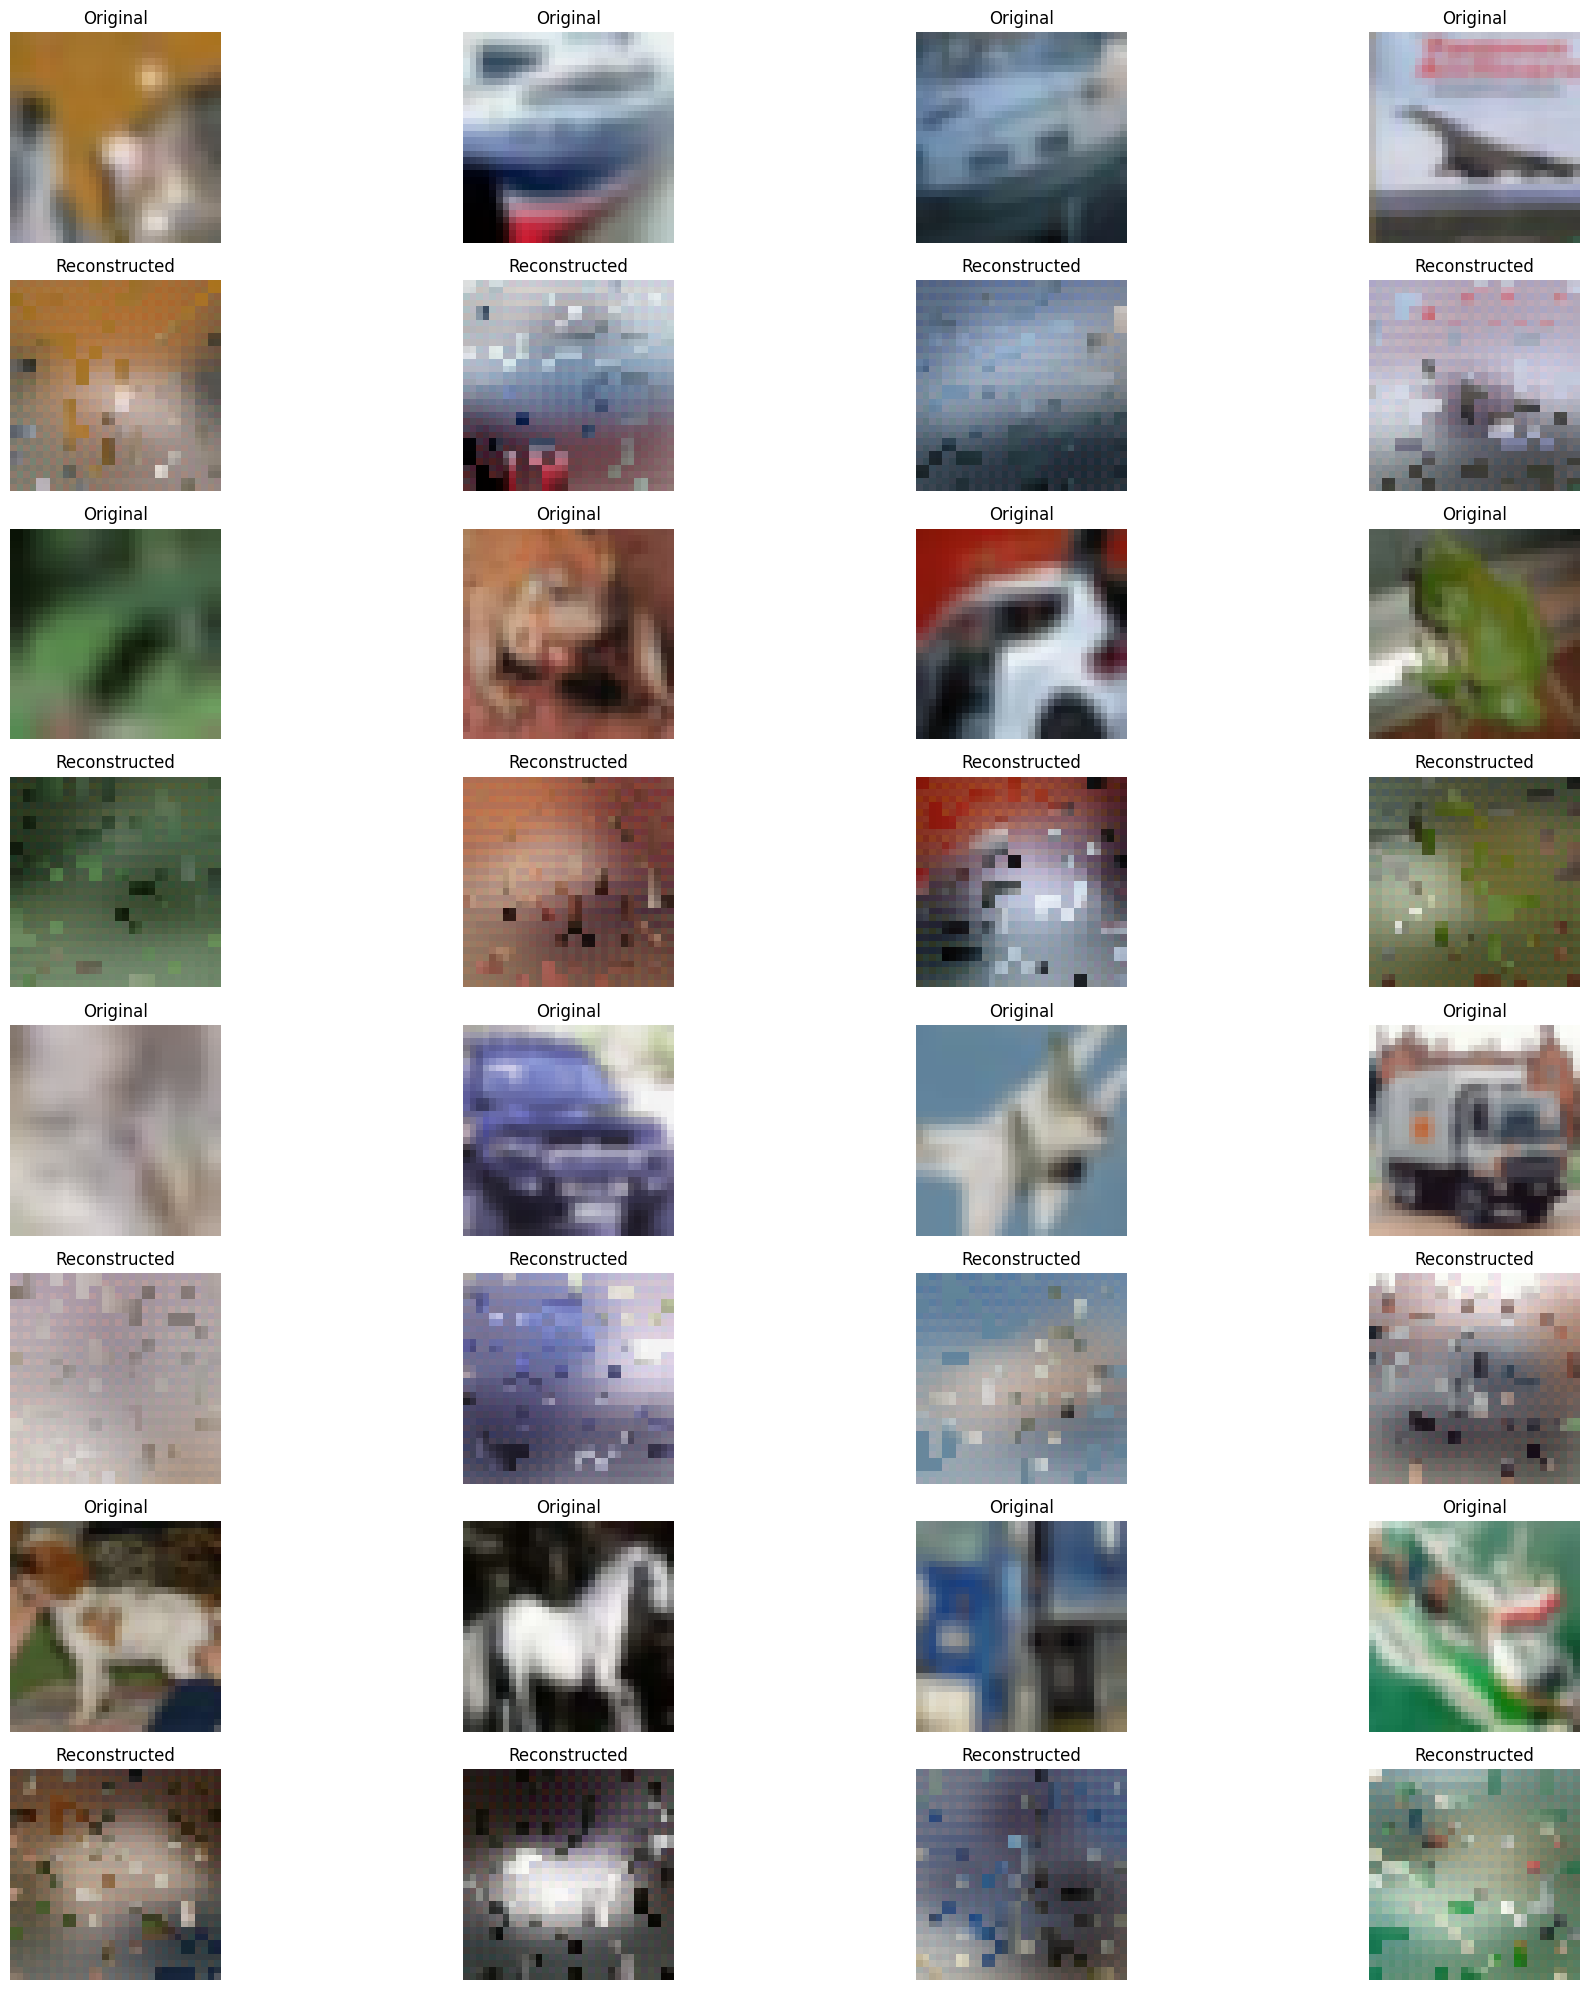

In [ ]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
import matplotlib.pyplot as plt


def set_seed(seed=42):
    """Set seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


# Dataset and DataLoader setup
def get_transforms():
    return Compose([
        RandomResizedCrop(32),  # Data augmentation
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize for CIFAR10
    ])

def get_dataloaders(batch_size):
    train_dataset = CIFAR10(root='/content/data', train=True, download=True, transform=get_transforms())
    val_dataset = CIFAR10(root='/content/data', train=False, download=True, transform=get_transforms())
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    return train_loader, val_loader

batch_size = 256
train_loader, val_loader = get_dataloaders(batch_size)
def visualize_original_and_reconstructed_images():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load the model
    model = MAEModel()
    model_path = '/content/drive/My Drive/Colab_Models/mae_pretrained_10.pth'
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Assuming val_loader is defined elsewhere and properly loaded
    with torch.no_grad():
        # Loading images from the validation dataset
        val_images, _ = next(iter(val_loader))
        val_images = val_images.to(device)
        total_images = 16
        predicted_images, masks = model(val_images)
        masks = masks.to(device)
        reconstructed_images = predicted_images * masks + val_images * (1 - masks)
        reconstructed_images = reconstructed_images.cpu()

    # Normalize and clamp the images for display
    val_images = val_images.cpu() * 0.5 + 0.5
    reconstructed_images = reconstructed_images * 0.5 + 0.5
    reconstructed_images = reconstructed_images.clamp(0, 1)

    # Visualization setup
    num_columns = 4
    num_rows = (total_images + num_columns - 1) // num_columns
    fig, axs = plt.subplots(num_rows * 2, num_columns, figsize=(20, 5 * num_rows))
    for i in range(total_images):
        row = i // num_columns
        col = i % num_columns
        axs[row * 2, col].imshow(val_images[i].permute(1, 2, 0))
        axs[row * 2, col].set_title('Original')
        axs[row * 2, col].axis('off')
        axs[row * 2 + 1, col].imshow(reconstructed_images[i].permute(1, 2, 0))
        axs[row * 2 + 1, col].set_title('Reconstructed')
        axs[row * 2 + 1, col].axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    visualize_original_and_reconstructed_images()

## Trained for 50 epochs

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 196/196 [01:07<00:00,  2.89it/s]


Epoch 1, Train Loss: 0.2805, Validation Loss: 0.1232


100%|██████████| 196/196 [01:07<00:00,  2.89it/s]


Epoch 2, Train Loss: 0.1192, Validation Loss: 0.1135


100%|██████████| 196/196 [01:07<00:00,  2.91it/s]


Epoch 3, Train Loss: 0.1042, Validation Loss: 0.1049


100%|██████████| 196/196 [01:07<00:00,  2.89it/s]


Epoch 4, Train Loss: 0.0972, Validation Loss: 0.0971


100%|██████████| 196/196 [01:08<00:00,  2.84it/s]


Epoch 5, Train Loss: 0.0928, Validation Loss: 0.0877


100%|██████████| 196/196 [01:07<00:00,  2.91it/s]


Epoch 6, Train Loss: 0.0848, Validation Loss: 0.0815


100%|██████████| 196/196 [01:07<00:00,  2.90it/s]


Epoch 7, Train Loss: 0.0808, Validation Loss: 0.0793


100%|██████████| 196/196 [01:08<00:00,  2.85it/s]


Epoch 8, Train Loss: 0.0743, Validation Loss: 0.0693


100%|██████████| 196/196 [01:07<00:00,  2.91it/s]


Epoch 9, Train Loss: 0.0644, Validation Loss: 0.0614


100%|██████████| 196/196 [01:07<00:00,  2.90it/s]


Epoch 10, Train Loss: 0.0572, Validation Loss: 0.0544


100%|██████████| 196/196 [01:08<00:00,  2.88it/s]


Epoch 11, Train Loss: 0.0521, Validation Loss: 0.0505


100%|██████████| 196/196 [01:07<00:00,  2.89it/s]


Epoch 12, Train Loss: 0.0451, Validation Loss: 0.0401


100%|██████████| 196/196 [01:07<00:00,  2.89it/s]


Epoch 13, Train Loss: 0.0349, Validation Loss: 0.0310


100%|██████████| 196/196 [01:08<00:00,  2.84it/s]


Epoch 14, Train Loss: 0.0289, Validation Loss: 0.0270


100%|██████████| 196/196 [01:07<00:00,  2.89it/s]


Epoch 15, Train Loss: 0.0260, Validation Loss: 0.0265


100%|██████████| 196/196 [01:07<00:00,  2.89it/s]


Epoch 16, Train Loss: 0.0240, Validation Loss: 0.0227


100%|██████████| 196/196 [01:08<00:00,  2.87it/s]


Epoch 17, Train Loss: 0.0225, Validation Loss: 0.0242


100%|██████████| 196/196 [01:08<00:00,  2.88it/s]


Epoch 18, Train Loss: 0.0212, Validation Loss: 0.0214


100%|██████████| 196/196 [01:08<00:00,  2.87it/s]


Epoch 19, Train Loss: 0.0199, Validation Loss: 0.0198


100%|██████████| 196/196 [01:08<00:00,  2.88it/s]


Epoch 20, Train Loss: 0.0188, Validation Loss: 0.0198


100%|██████████| 196/196 [01:08<00:00,  2.86it/s]


Epoch 21, Train Loss: 0.0180, Validation Loss: 0.0185


100%|██████████| 196/196 [01:07<00:00,  2.89it/s]


Epoch 22, Train Loss: 0.0175, Validation Loss: 0.0174


100%|██████████| 196/196 [01:08<00:00,  2.88it/s]


Epoch 23, Train Loss: 0.0170, Validation Loss: 0.0169


100%|██████████| 196/196 [01:08<00:00,  2.84it/s]


Epoch 24, Train Loss: 0.0167, Validation Loss: 0.0168


100%|██████████| 196/196 [01:07<00:00,  2.89it/s]


Epoch 25, Train Loss: 0.0164, Validation Loss: 0.0161


100%|██████████| 196/196 [01:08<00:00,  2.88it/s]


Epoch 26, Train Loss: 0.0161, Validation Loss: 0.0160


100%|██████████| 196/196 [01:09<00:00,  2.84it/s]


Epoch 27, Train Loss: 0.0157, Validation Loss: 0.0156


100%|██████████| 196/196 [01:07<00:00,  2.89it/s]


Epoch 28, Train Loss: 0.0154, Validation Loss: 0.0156


100%|██████████| 196/196 [01:08<00:00,  2.87it/s]


Epoch 29, Train Loss: 0.0153, Validation Loss: 0.0151


100%|██████████| 196/196 [01:08<00:00,  2.85it/s]


Epoch 30, Train Loss: 0.0149, Validation Loss: 0.0151


100%|██████████| 196/196 [01:07<00:00,  2.89it/s]


Epoch 31, Train Loss: 0.0149, Validation Loss: 0.0154


100%|██████████| 196/196 [01:08<00:00,  2.88it/s]


Epoch 32, Train Loss: 0.0146, Validation Loss: 0.0148


100%|██████████| 196/196 [01:08<00:00,  2.87it/s]


Epoch 33, Train Loss: 0.0145, Validation Loss: 0.0145


100%|██████████| 196/196 [01:07<00:00,  2.90it/s]


Epoch 34, Train Loss: 0.0144, Validation Loss: 0.0145


100%|██████████| 196/196 [01:07<00:00,  2.89it/s]


Epoch 35, Train Loss: 0.0141, Validation Loss: 0.0152


100%|██████████| 196/196 [01:07<00:00,  2.89it/s]


Epoch 36, Train Loss: 0.0141, Validation Loss: 0.0145


100%|██████████| 196/196 [01:08<00:00,  2.85it/s]


Epoch 37, Train Loss: 0.0139, Validation Loss: 0.0143


100%|██████████| 196/196 [01:07<00:00,  2.88it/s]


Epoch 38, Train Loss: 0.0138, Validation Loss: 0.0137


100%|██████████| 196/196 [01:08<00:00,  2.87it/s]


Epoch 39, Train Loss: 0.0138, Validation Loss: 0.0136


100%|██████████| 196/196 [01:08<00:00,  2.85it/s]


Epoch 40, Train Loss: 0.0136, Validation Loss: 0.0139


100%|██████████| 196/196 [01:07<00:00,  2.89it/s]


Epoch 41, Train Loss: 0.0134, Validation Loss: 0.0138


100%|██████████| 196/196 [01:08<00:00,  2.87it/s]


Epoch 42, Train Loss: 0.0134, Validation Loss: 0.0134


100%|██████████| 196/196 [01:08<00:00,  2.86it/s]


Epoch 43, Train Loss: 0.0133, Validation Loss: 0.0136


100%|██████████| 196/196 [01:07<00:00,  2.90it/s]


Epoch 44, Train Loss: 0.0131, Validation Loss: 0.0131


100%|██████████| 196/196 [01:07<00:00,  2.88it/s]


Epoch 45, Train Loss: 0.0130, Validation Loss: 0.0132


100%|██████████| 196/196 [01:08<00:00,  2.86it/s]


Epoch 46, Train Loss: 0.0130, Validation Loss: 0.0132


100%|██████████| 196/196 [01:08<00:00,  2.88it/s]


Epoch 47, Train Loss: 0.0128, Validation Loss: 0.0129


100%|██████████| 196/196 [01:07<00:00,  2.89it/s]


Epoch 48, Train Loss: 0.0128, Validation Loss: 0.0127


100%|██████████| 196/196 [01:08<00:00,  2.86it/s]


Epoch 49, Train Loss: 0.0126, Validation Loss: 0.0129


100%|██████████| 196/196 [01:07<00:00,  2.89it/s]


Epoch 50, Train Loss: 0.0126, Validation Loss: 0.0126
Loss data saved to /content/drive/My Drive/Colab_Models/loss_data_50.csv
Model saved to /content/drive/My Drive/Colab_Models/mae_pretrained_50.pth


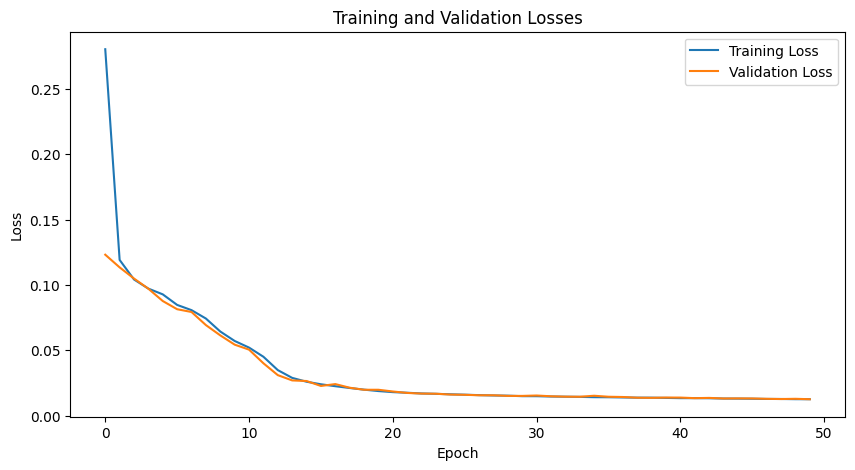

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize, RandomResizedCrop
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import csv  # Import csv module
from google.colab import drive
drive.mount('/content/drive')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def set_seed(seed=42):
    """Set seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Dataset and DataLoader setup
def get_transforms():
    return Compose([
        RandomResizedCrop(32),  # Data augmentation
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize for CIFAR10
    ])

def get_dataloaders(batch_size):
    train_dataset = CIFAR10(root='/content/data', train=True, download=True, transform=get_transforms())
    val_dataset = CIFAR10(root='/content/data', train=False, download=True, transform=get_transforms())
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    return train_loader, val_loader

batch_size = 256
train_loader, val_loader = get_dataloaders(batch_size)

# Initialize the model, optimizer, and loss criterion
model = MAEModel().to(device)  # Ensure MAEModel is defined elsewhere in your script

# Initialize transformer blocks with Xavier uniform
def initialize_model(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

initialize_model(model)

# Adjusted learning rate according to the linear scaling rule
base_lr = 1.5e-4 * (batch_size / 256)
optimizer = optim.AdamW(model.parameters(), lr=base_lr, betas=(0.9, 0.95), weight_decay=0.05)
criterion = nn.MSELoss()

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0)  # Cosine decay

# Lists to hold loss data for plotting
train_losses = []
val_losses = []

# Training and validation functions
def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    for images, _ in tqdm(dataloader):
        images = images.to(device)
        optimizer.zero_grad()
        reconstructed_images, mask = model(images)
        mask = mask.to(device)
        loss = criterion(reconstructed_images * mask, images * mask)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler.step()  # Update the learning rate
    return total_loss / len(dataloader)



def validate(model, dataloader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            reconstructed_images, mask = model(images)
            mask = mask.to(device)
            loss = criterion(reconstructed_images * mask, images * mask)
            total_loss += loss.item()
    return total_loss / len(dataloader)
num_epochs = 50
# Training loop
for epoch in range(num_epochs):
    if epoch < 40:  # Warmup epochs
        scheduler.base_lrs = [base_lr * (epoch + 1) / 40 for _ in optimizer.param_groups]
    train_loss = train_one_epoch(model, train_loader, optimizer, device)
    val_loss = validate(model, val_loader, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')


folder_path = '/content/drive/My Drive/Colab_Models'
# Save the loss data to a CSV file
loss_data_path = os.path.join(folder_path, 'loss_data_50.csv')
with open(loss_data_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Epoch', 'Train Loss', 'Validation Loss'])
    for i, (t_loss, v_loss) in enumerate(zip(train_losses, val_losses)):
        writer.writerow([i + 1, t_loss, v_loss])

print(f"Loss data saved to {loss_data_path}")

# Save the model's state
os.makedirs(folder_path, exist_ok=True)
model_save_path = os.path.join(folder_path, 'mae_pretrained_50.pth')
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Files already downloaded and verified
Files already downloaded and verified


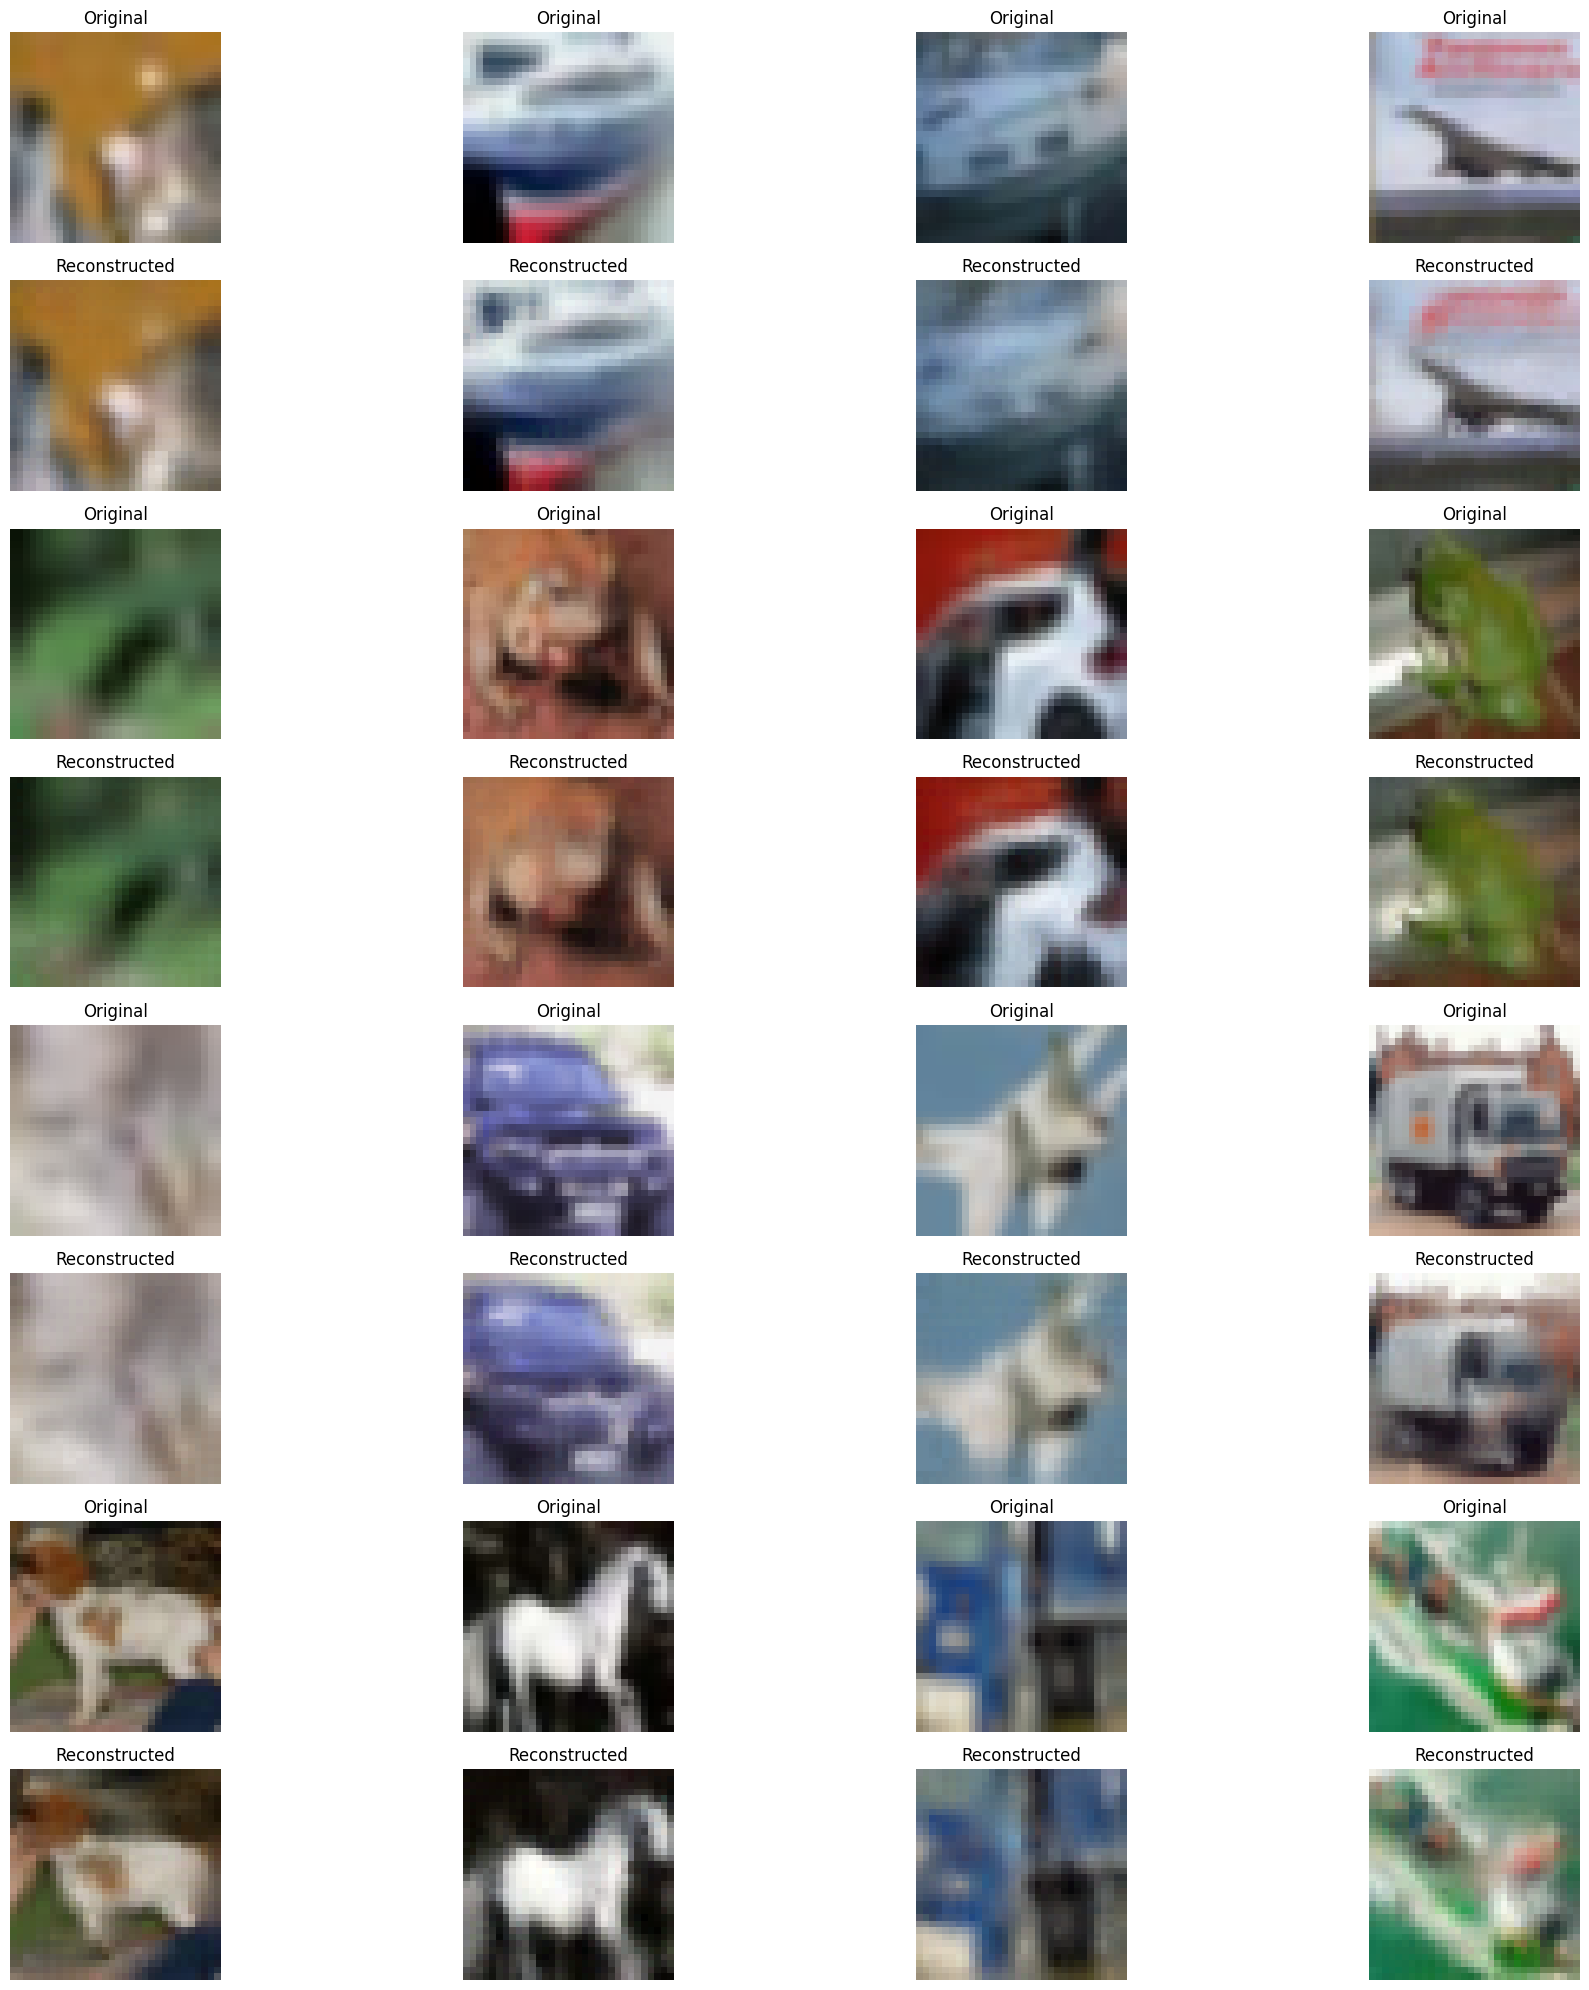

In [ ]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
import matplotlib.pyplot as plt


def set_seed(seed=42):
    """Set seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


# Dataset and DataLoader setup
def get_transforms():
    return Compose([
        RandomResizedCrop(32),  # Data augmentation
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize for CIFAR10
    ])

def get_dataloaders(batch_size):
    train_dataset = CIFAR10(root='/content/data', train=True, download=True, transform=get_transforms())
    val_dataset = CIFAR10(root='/content/data', train=False, download=True, transform=get_transforms())
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    return train_loader, val_loader

batch_size = 256
train_loader, val_loader = get_dataloaders(batch_size)
def visualize_original_and_reconstructed_images():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load the model
    model = MAEModel()
    model_path = '/content/drive/My Drive/Colab_Models/mae_pretrained_50.pth'
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Assuming val_loader is defined elsewhere and properly loaded
    with torch.no_grad():
        # Loading images from the validation dataset
        val_images, _ = next(iter(val_loader))
        val_images = val_images.to(device)
        total_images = 16
        predicted_images, masks = model(val_images)
        masks = masks.to(device)
        reconstructed_images = predicted_images * masks + val_images * (1 - masks)
        reconstructed_images = reconstructed_images.cpu()

    # Normalize and clamp the images for display
    val_images = val_images.cpu() * 0.5 + 0.5
    reconstructed_images = reconstructed_images * 0.5 + 0.5
    reconstructed_images = reconstructed_images.clamp(0, 1)

    # Visualization setup
    num_columns = 4
    num_rows = (total_images + num_columns - 1) // num_columns
    fig, axs = plt.subplots(num_rows * 2, num_columns, figsize=(20, 5 * num_rows))
    for i in range(total_images):
        row = i // num_columns
        col = i % num_columns
        axs[row * 2, col].imshow(val_images[i].permute(1, 2, 0))
        axs[row * 2, col].set_title('Original')
        axs[row * 2, col].axis('off')
        axs[row * 2 + 1, col].imshow(reconstructed_images[i].permute(1, 2, 0))
        axs[row * 2 + 1, col].set_title('Reconstructed')
        axs[row * 2 + 1, col].axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    visualize_original_and_reconstructed_images()

## Trained for 100 epochs

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 196/196 [01:03<00:00,  3.08it/s]


Epoch 1, Train Loss: 0.2804, Validation Loss: 0.1270


100%|██████████| 196/196 [01:03<00:00,  3.11it/s]


Epoch 2, Train Loss: 0.1190, Validation Loss: 0.1126


100%|██████████| 196/196 [01:03<00:00,  3.11it/s]


Epoch 3, Train Loss: 0.1038, Validation Loss: 0.1069


100%|██████████| 196/196 [01:02<00:00,  3.11it/s]


Epoch 4, Train Loss: 0.0970, Validation Loss: 0.0975


100%|██████████| 196/196 [01:03<00:00,  3.10it/s]


Epoch 5, Train Loss: 0.0929, Validation Loss: 0.0885


100%|██████████| 196/196 [01:02<00:00,  3.13it/s]


Epoch 6, Train Loss: 0.0848, Validation Loss: 0.0827


100%|██████████| 196/196 [01:02<00:00,  3.12it/s]


Epoch 7, Train Loss: 0.0808, Validation Loss: 0.0802


100%|██████████| 196/196 [01:03<00:00,  3.08it/s]


Epoch 8, Train Loss: 0.0753, Validation Loss: 0.0714


100%|██████████| 196/196 [01:03<00:00,  3.08it/s]


Epoch 9, Train Loss: 0.0643, Validation Loss: 0.0596


100%|██████████| 196/196 [01:03<00:00,  3.10it/s]


Epoch 10, Train Loss: 0.0530, Validation Loss: 0.0452


100%|██████████| 196/196 [01:03<00:00,  3.09it/s]


Epoch 11, Train Loss: 0.0378, Validation Loss: 0.0346


100%|██████████| 196/196 [01:02<00:00,  3.12it/s]


Epoch 12, Train Loss: 0.0313, Validation Loss: 0.0309


100%|██████████| 196/196 [01:02<00:00,  3.11it/s]


Epoch 13, Train Loss: 0.0278, Validation Loss: 0.0258


100%|██████████| 196/196 [01:03<00:00,  3.09it/s]


Epoch 14, Train Loss: 0.0255, Validation Loss: 0.0247


100%|██████████| 196/196 [01:03<00:00,  3.09it/s]


Epoch 15, Train Loss: 0.0240, Validation Loss: 0.0229


100%|██████████| 196/196 [01:03<00:00,  3.08it/s]


Epoch 16, Train Loss: 0.0227, Validation Loss: 0.0219


100%|██████████| 196/196 [01:03<00:00,  3.10it/s]


Epoch 17, Train Loss: 0.0214, Validation Loss: 0.0207


100%|██████████| 196/196 [01:03<00:00,  3.09it/s]


Epoch 18, Train Loss: 0.0204, Validation Loss: 0.0207


100%|██████████| 196/196 [01:02<00:00,  3.12it/s]


Epoch 19, Train Loss: 0.0193, Validation Loss: 0.0192


100%|██████████| 196/196 [01:03<00:00,  3.10it/s]


Epoch 20, Train Loss: 0.0187, Validation Loss: 0.0190


100%|██████████| 196/196 [01:03<00:00,  3.11it/s]


Epoch 21, Train Loss: 0.0180, Validation Loss: 0.0178


100%|██████████| 196/196 [01:03<00:00,  3.08it/s]


Epoch 22, Train Loss: 0.0177, Validation Loss: 0.0176


100%|██████████| 196/196 [01:02<00:00,  3.12it/s]


Epoch 23, Train Loss: 0.0172, Validation Loss: 0.0169


100%|██████████| 196/196 [01:02<00:00,  3.12it/s]


Epoch 24, Train Loss: 0.0169, Validation Loss: 0.0169


100%|██████████| 196/196 [01:03<00:00,  3.09it/s]


Epoch 25, Train Loss: 0.0166, Validation Loss: 0.0164


100%|██████████| 196/196 [01:02<00:00,  3.12it/s]


Epoch 26, Train Loss: 0.0164, Validation Loss: 0.0164


100%|██████████| 196/196 [01:02<00:00,  3.11it/s]


Epoch 27, Train Loss: 0.0161, Validation Loss: 0.0167


100%|██████████| 196/196 [01:02<00:00,  3.13it/s]


Epoch 28, Train Loss: 0.0158, Validation Loss: 0.0160


100%|██████████| 196/196 [01:03<00:00,  3.10it/s]


Epoch 29, Train Loss: 0.0158, Validation Loss: 0.0157


100%|██████████| 196/196 [01:03<00:00,  3.10it/s]


Epoch 30, Train Loss: 0.0154, Validation Loss: 0.0159


100%|██████████| 196/196 [01:03<00:00,  3.10it/s]


Epoch 31, Train Loss: 0.0153, Validation Loss: 0.0157


100%|██████████| 196/196 [01:03<00:00,  3.09it/s]


Epoch 32, Train Loss: 0.0151, Validation Loss: 0.0155


100%|██████████| 196/196 [01:02<00:00,  3.11it/s]


Epoch 33, Train Loss: 0.0150, Validation Loss: 0.0153


100%|██████████| 196/196 [01:02<00:00,  3.12it/s]


Epoch 34, Train Loss: 0.0149, Validation Loss: 0.0149


100%|██████████| 196/196 [01:02<00:00,  3.12it/s]


Epoch 35, Train Loss: 0.0147, Validation Loss: 0.0154


100%|██████████| 196/196 [01:03<00:00,  3.10it/s]


Epoch 36, Train Loss: 0.0146, Validation Loss: 0.0151


100%|██████████| 196/196 [01:02<00:00,  3.12it/s]


Epoch 37, Train Loss: 0.0144, Validation Loss: 0.0149


100%|██████████| 196/196 [01:02<00:00,  3.12it/s]


Epoch 38, Train Loss: 0.0143, Validation Loss: 0.0143


100%|██████████| 196/196 [01:03<00:00,  3.10it/s]


Epoch 39, Train Loss: 0.0143, Validation Loss: 0.0141


100%|██████████| 196/196 [01:03<00:00,  3.08it/s]


Epoch 40, Train Loss: 0.0141, Validation Loss: 0.0146


100%|██████████| 196/196 [01:02<00:00,  3.12it/s]


Epoch 41, Train Loss: 0.0139, Validation Loss: 0.0141


100%|██████████| 196/196 [01:02<00:00,  3.12it/s]


Epoch 42, Train Loss: 0.0139, Validation Loss: 0.0138


100%|██████████| 196/196 [01:03<00:00,  3.09it/s]


Epoch 43, Train Loss: 0.0138, Validation Loss: 0.0144


100%|██████████| 196/196 [01:02<00:00,  3.12it/s]


Epoch 44, Train Loss: 0.0136, Validation Loss: 0.0138


100%|██████████| 196/196 [01:02<00:00,  3.11it/s]


Epoch 45, Train Loss: 0.0136, Validation Loss: 0.0142


100%|██████████| 196/196 [01:03<00:00,  3.09it/s]


Epoch 46, Train Loss: 0.0136, Validation Loss: 0.0140


100%|██████████| 196/196 [01:03<00:00,  3.10it/s]


Epoch 47, Train Loss: 0.0134, Validation Loss: 0.0133


100%|██████████| 196/196 [01:03<00:00,  3.08it/s]


Epoch 48, Train Loss: 0.0134, Validation Loss: 0.0134


100%|██████████| 196/196 [01:02<00:00,  3.12it/s]


Epoch 49, Train Loss: 0.0132, Validation Loss: 0.0134


100%|██████████| 196/196 [01:03<00:00,  3.10it/s]


Epoch 50, Train Loss: 0.0132, Validation Loss: 0.0132


100%|██████████| 196/196 [01:03<00:00,  3.10it/s]


Epoch 51, Train Loss: 0.0131, Validation Loss: 0.0132


100%|██████████| 196/196 [01:02<00:00,  3.11it/s]


Epoch 52, Train Loss: 0.0131, Validation Loss: 0.0130


100%|██████████| 196/196 [01:03<00:00,  3.10it/s]


Epoch 53, Train Loss: 0.0129, Validation Loss: 0.0131


100%|██████████| 196/196 [01:03<00:00,  3.09it/s]


Epoch 54, Train Loss: 0.0129, Validation Loss: 0.0132


100%|██████████| 196/196 [01:03<00:00,  3.08it/s]


Epoch 55, Train Loss: 0.0128, Validation Loss: 0.0127


100%|██████████| 196/196 [01:03<00:00,  3.10it/s]


Epoch 56, Train Loss: 0.0127, Validation Loss: 0.0129


100%|██████████| 196/196 [01:03<00:00,  3.08it/s]


Epoch 57, Train Loss: 0.0126, Validation Loss: 0.0130


100%|██████████| 196/196 [01:02<00:00,  3.13it/s]


Epoch 58, Train Loss: 0.0126, Validation Loss: 0.0128


100%|██████████| 196/196 [01:02<00:00,  3.12it/s]


Epoch 59, Train Loss: 0.0125, Validation Loss: 0.0124


100%|██████████| 196/196 [01:03<00:00,  3.09it/s]


Epoch 60, Train Loss: 0.0124, Validation Loss: 0.0126


100%|██████████| 196/196 [01:03<00:00,  3.08it/s]


Epoch 61, Train Loss: 0.0125, Validation Loss: 0.0128


100%|██████████| 196/196 [01:04<00:00,  3.06it/s]


Epoch 62, Train Loss: 0.0124, Validation Loss: 0.0123


100%|██████████| 196/196 [01:03<00:00,  3.07it/s]


Epoch 63, Train Loss: 0.0123, Validation Loss: 0.0124


100%|██████████| 196/196 [01:03<00:00,  3.11it/s]


Epoch 64, Train Loss: 0.0123, Validation Loss: 0.0124


100%|██████████| 196/196 [01:02<00:00,  3.12it/s]


Epoch 65, Train Loss: 0.0122, Validation Loss: 0.0125


100%|██████████| 196/196 [01:02<00:00,  3.12it/s]


Epoch 66, Train Loss: 0.0121, Validation Loss: 0.0123


100%|██████████| 196/196 [01:03<00:00,  3.08it/s]


Epoch 67, Train Loss: 0.0121, Validation Loss: 0.0122


100%|██████████| 196/196 [01:02<00:00,  3.11it/s]


Epoch 68, Train Loss: 0.0121, Validation Loss: 0.0123


100%|██████████| 196/196 [01:03<00:00,  3.10it/s]


Epoch 69, Train Loss: 0.0121, Validation Loss: 0.0120


100%|██████████| 196/196 [01:03<00:00,  3.09it/s]


Epoch 70, Train Loss: 0.0120, Validation Loss: 0.0120


100%|██████████| 196/196 [01:02<00:00,  3.13it/s]


Epoch 71, Train Loss: 0.0120, Validation Loss: 0.0118


100%|██████████| 196/196 [01:02<00:00,  3.12it/s]


Epoch 72, Train Loss: 0.0119, Validation Loss: 0.0122


100%|██████████| 196/196 [01:02<00:00,  3.12it/s]


Epoch 73, Train Loss: 0.0119, Validation Loss: 0.0119


100%|██████████| 196/196 [01:03<00:00,  3.09it/s]


Epoch 74, Train Loss: 0.0119, Validation Loss: 0.0121


100%|██████████| 196/196 [01:03<00:00,  3.11it/s]


Epoch 75, Train Loss: 0.0119, Validation Loss: 0.0119


100%|██████████| 196/196 [01:03<00:00,  3.09it/s]


Epoch 76, Train Loss: 0.0118, Validation Loss: 0.0121


100%|██████████| 196/196 [01:04<00:00,  3.06it/s]


Epoch 77, Train Loss: 0.0118, Validation Loss: 0.0116


100%|██████████| 196/196 [01:03<00:00,  3.09it/s]


Epoch 78, Train Loss: 0.0117, Validation Loss: 0.0117


100%|██████████| 196/196 [01:03<00:00,  3.08it/s]


Epoch 79, Train Loss: 0.0117, Validation Loss: 0.0117


100%|██████████| 196/196 [01:03<00:00,  3.10it/s]


Epoch 80, Train Loss: 0.0117, Validation Loss: 0.0116


100%|██████████| 196/196 [01:03<00:00,  3.09it/s]


Epoch 81, Train Loss: 0.0117, Validation Loss: 0.0118


100%|██████████| 196/196 [01:02<00:00,  3.12it/s]


Epoch 82, Train Loss: 0.0116, Validation Loss: 0.0119


100%|██████████| 196/196 [01:02<00:00,  3.13it/s]


Epoch 83, Train Loss: 0.0117, Validation Loss: 0.0119


100%|██████████| 196/196 [01:03<00:00,  3.11it/s]


Epoch 84, Train Loss: 0.0116, Validation Loss: 0.0115


100%|██████████| 196/196 [01:02<00:00,  3.12it/s]


Epoch 85, Train Loss: 0.0115, Validation Loss: 0.0117


100%|██████████| 196/196 [01:02<00:00,  3.12it/s]


Epoch 86, Train Loss: 0.0116, Validation Loss: 0.0117


100%|██████████| 196/196 [01:02<00:00,  3.12it/s]


Epoch 87, Train Loss: 0.0116, Validation Loss: 0.0117


100%|██████████| 196/196 [01:03<00:00,  3.07it/s]


Epoch 88, Train Loss: 0.0116, Validation Loss: 0.0115


100%|██████████| 196/196 [01:03<00:00,  3.09it/s]


Epoch 89, Train Loss: 0.0116, Validation Loss: 0.0115


100%|██████████| 196/196 [01:03<00:00,  3.09it/s]


Epoch 90, Train Loss: 0.0115, Validation Loss: 0.0116


100%|██████████| 196/196 [01:03<00:00,  3.08it/s]


Epoch 91, Train Loss: 0.0115, Validation Loss: 0.0115


100%|██████████| 196/196 [01:03<00:00,  3.11it/s]


Epoch 92, Train Loss: 0.0115, Validation Loss: 0.0115


100%|██████████| 196/196 [01:03<00:00,  3.10it/s]


Epoch 93, Train Loss: 0.0114, Validation Loss: 0.0115


100%|██████████| 196/196 [01:02<00:00,  3.12it/s]


Epoch 94, Train Loss: 0.0115, Validation Loss: 0.0115


100%|██████████| 196/196 [01:03<00:00,  3.10it/s]


Epoch 95, Train Loss: 0.0115, Validation Loss: 0.0115


100%|██████████| 196/196 [01:02<00:00,  3.11it/s]


Epoch 96, Train Loss: 0.0114, Validation Loss: 0.0114


100%|██████████| 196/196 [01:03<00:00,  3.08it/s]


Epoch 97, Train Loss: 0.0115, Validation Loss: 0.0115


100%|██████████| 196/196 [01:04<00:00,  3.04it/s]


Epoch 98, Train Loss: 0.0114, Validation Loss: 0.0116


100%|██████████| 196/196 [01:03<00:00,  3.08it/s]


Epoch 99, Train Loss: 0.0114, Validation Loss: 0.0114


100%|██████████| 196/196 [01:03<00:00,  3.07it/s]


Epoch 100, Train Loss: 0.0115, Validation Loss: 0.0115
Loss data saved to /content/drive/My Drive/Colab_Models/loss_data.csv
Model saved to /content/drive/My Drive/Colab_Models/mae_pretrained_100.pth


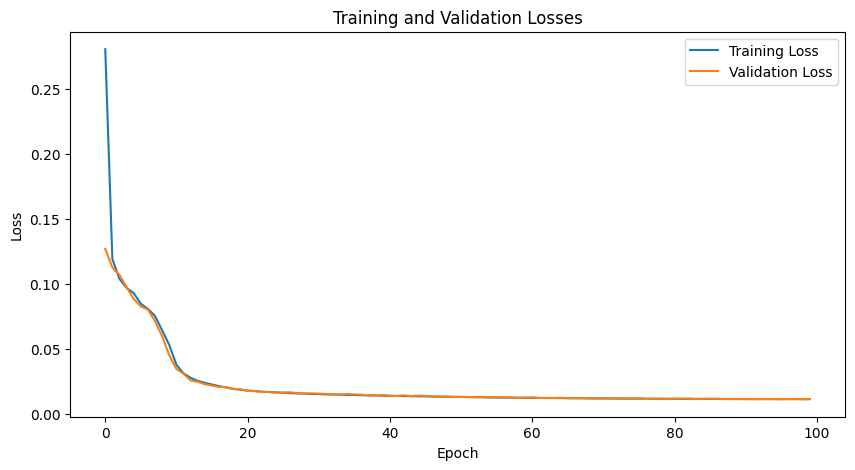

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize, RandomResizedCrop
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import csv  # Import csv module
from google.colab import drive
drive.mount('/content/drive')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def set_seed(seed=42):
    """Set seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Dataset and DataLoader setup
def get_transforms():
    return Compose([
        RandomResizedCrop(32),  # Data augmentation
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize for CIFAR10
    ])

def get_dataloaders(batch_size):
    train_dataset = CIFAR10(root='/content/data', train=True, download=True, transform=get_transforms())
    val_dataset = CIFAR10(root='/content/data', train=False, download=True, transform=get_transforms())
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    return train_loader, val_loader

batch_size = 256
train_loader, val_loader = get_dataloaders(batch_size)

# Initialize the model, optimizer, and loss criterion
model = MAEModel().to(device)  # Ensure MAEModel is defined elsewhere in your script

# Initialize transformer blocks with Xavier uniform
def initialize_model(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

initialize_model(model)

# Adjusted learning rate according to the linear scaling rule
base_lr = 1.5e-4 * (batch_size / 256)
optimizer = optim.AdamW(model.parameters(), lr=base_lr, betas=(0.9, 0.95), weight_decay=0.05)
criterion = nn.MSELoss()

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0)  # Cosine decay

# Lists to hold loss data for plotting
train_losses = []
val_losses = []

# Training and validation functions
def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    for images, _ in tqdm(dataloader):
        images = images.to(device)
        optimizer.zero_grad()
        reconstructed_images, mask = model(images)
        loss = criterion(reconstructed_images * mask, images * mask)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler.step()  # Update the learning rate
    return total_loss / len(dataloader)

def validate(model, dataloader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            reconstructed_images, mask = model(images)
            loss = criterion(reconstructed_images * mask, images * mask)
            total_loss += loss.item()
    return total_loss / len(dataloader)
num_epochs = 100
# Training loop
for epoch in range(num_epochs):
    if epoch < 40:  # Warmup epochs
        scheduler.base_lrs = [base_lr * (epoch + 1) / 40 for _ in optimizer.param_groups]
    train_loss = train_one_epoch(model, train_loader, optimizer, device)
    val_loss = validate(model, val_loader, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')


folder_path = '/content/drive/My Drive/Colab_Models'
# Save the loss data to a CSV file
loss_data_path = os.path.join(folder_path, 'loss_data.csv')
with open(loss_data_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Epoch', 'Train Loss', 'Validation Loss'])
    for i, (t_loss, v_loss) in enumerate(zip(train_losses, val_losses)):
        writer.writerow([i + 1, t_loss, v_loss])

print(f"Loss data saved to {loss_data_path}")

# Save the model's state
os.makedirs(folder_path, exist_ok=True)
model_save_path = os.path.join(folder_path, 'mae_pretrained_100.pth')
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


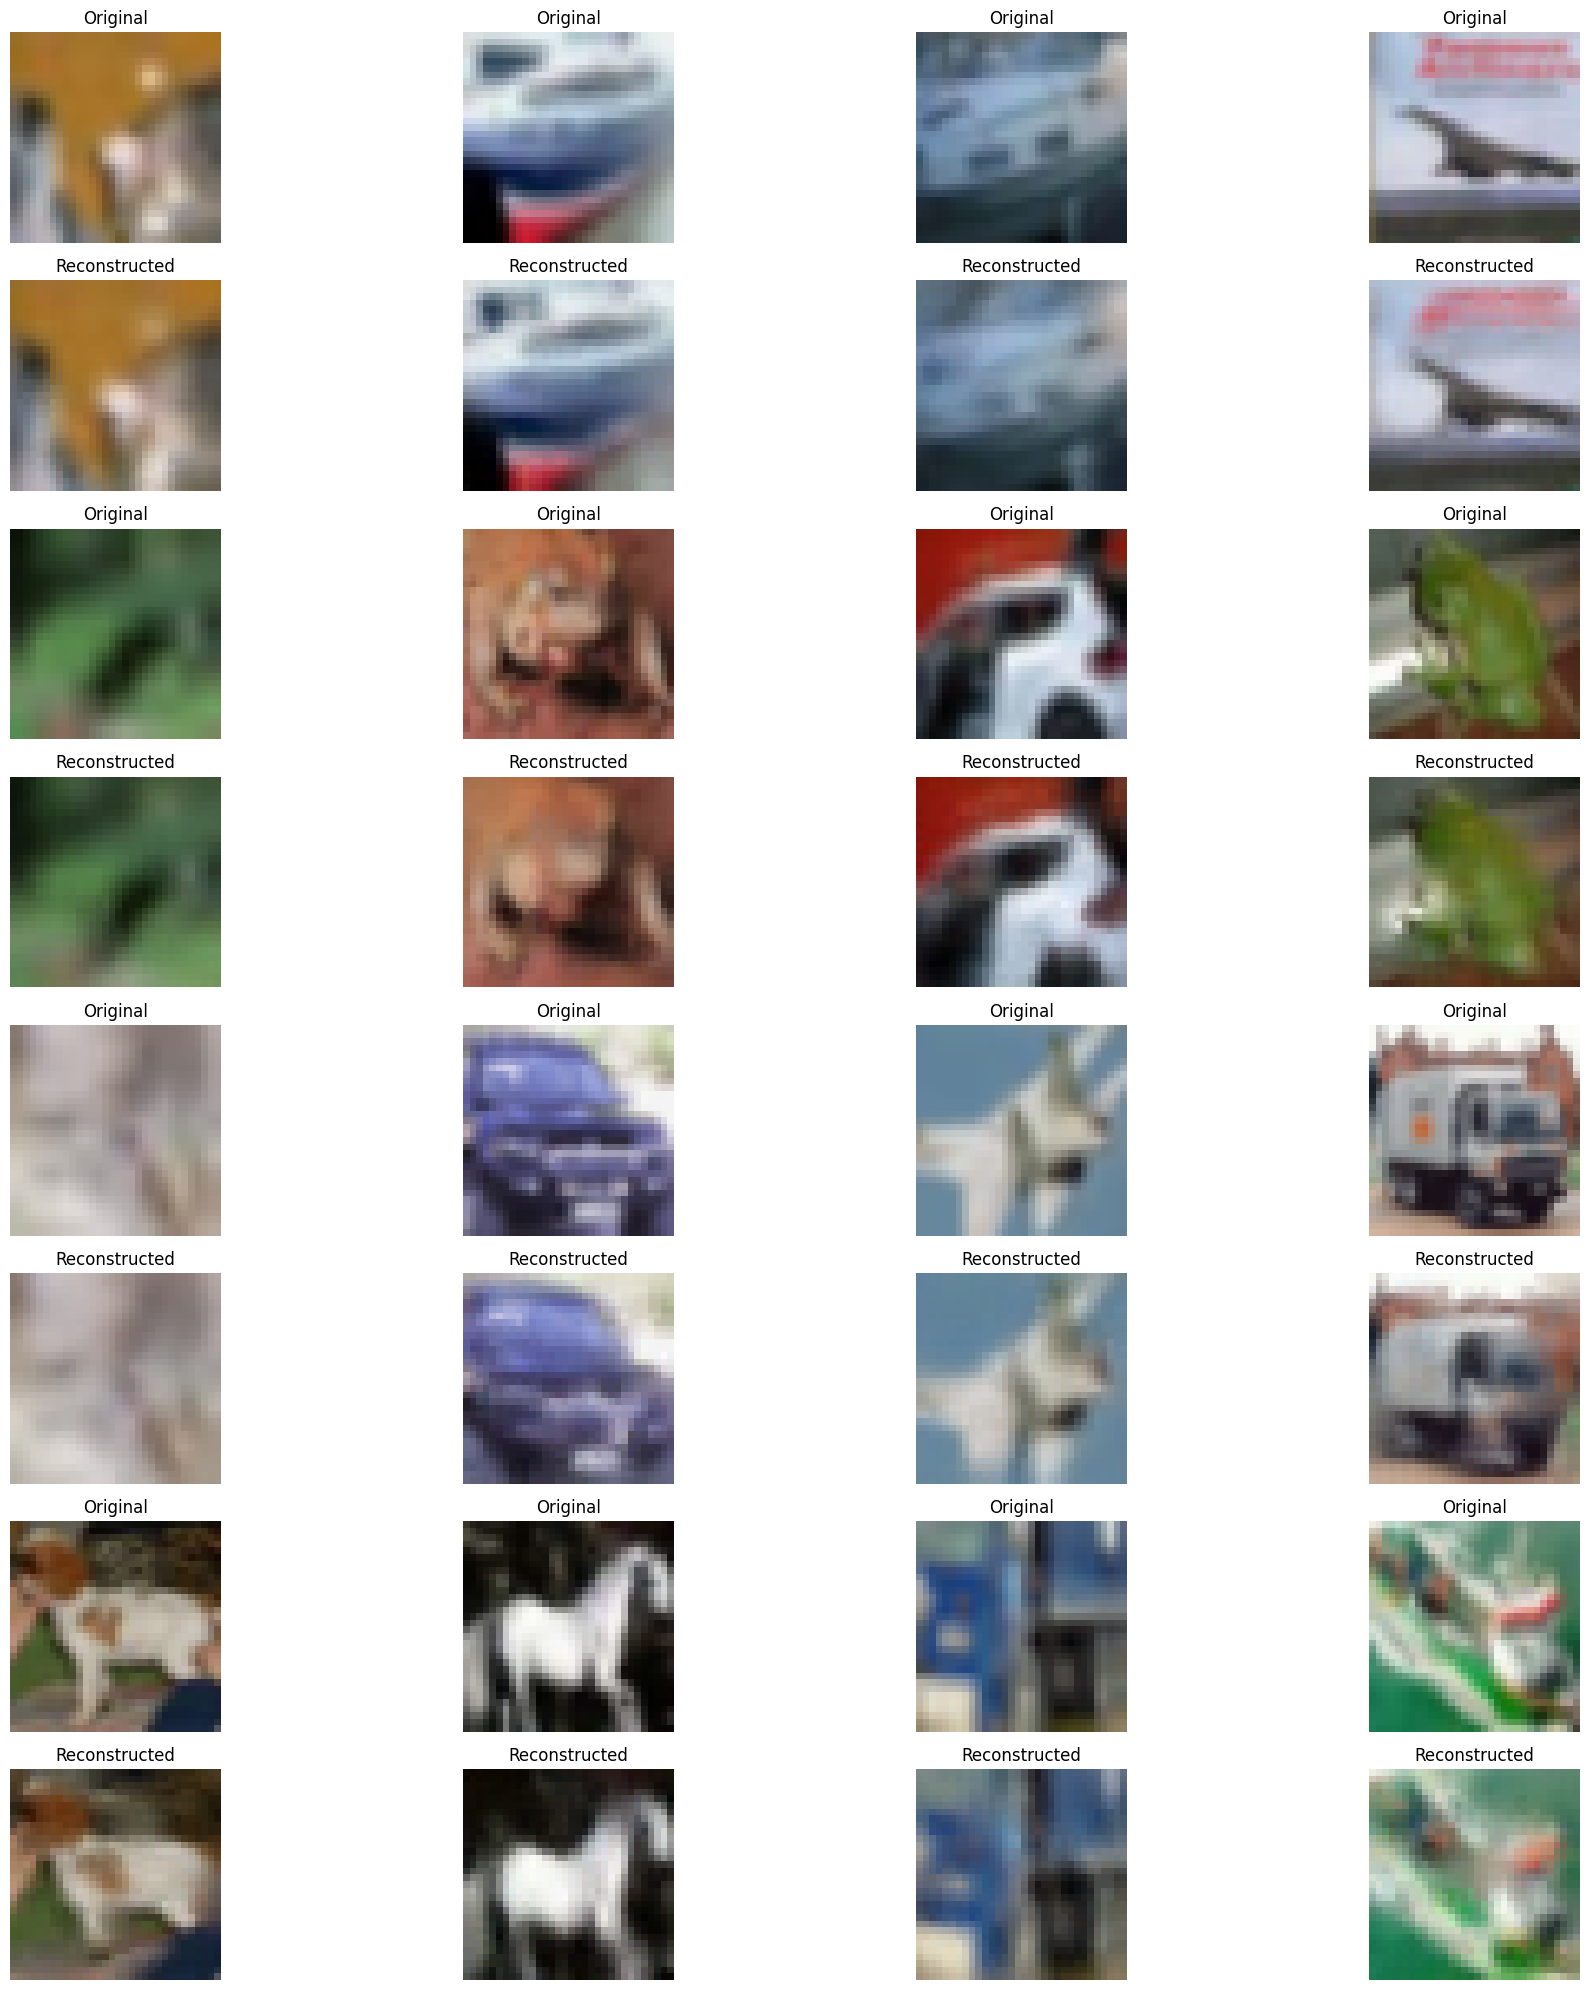

In [ ]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
import matplotlib.pyplot as plt


def set_seed(seed=42):
    """Set seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


# Dataset and DataLoader setup
def get_transforms():
    return Compose([
        RandomResizedCrop(32),  # Data augmentation
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize for CIFAR10
    ])

def get_dataloaders(batch_size):
    train_dataset = CIFAR10(root='/content/data', train=True, download=True, transform=get_transforms())
    val_dataset = CIFAR10(root='/content/data', train=False, download=True, transform=get_transforms())
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    return train_loader, val_loader

batch_size = 256
train_loader, val_loader = get_dataloaders(batch_size)
def visualize_original_and_reconstructed_images():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load the model
    model = MAEModel()
    model_path = '/content/drive/My Drive/Colab_Models/mae_pretrained_100.pth'
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Assuming val_loader is defined elsewhere and properly loaded
    with torch.no_grad():
        # Loading images from the validation dataset
        val_images, _ = next(iter(val_loader))
        val_images = val_images.to(device)
        total_images = 16
        predicted_images, masks = model(val_images)
        masks = masks.to(device)
        reconstructed_images = predicted_images * masks + val_images * (1 - masks)
        reconstructed_images = reconstructed_images.cpu()

    # Normalize and clamp the images for display
    val_images = val_images.cpu() * 0.5 + 0.5
    reconstructed_images = reconstructed_images * 0.5 + 0.5
    reconstructed_images = reconstructed_images.clamp(0, 1)

    # Visualization setup
    num_columns = 4
    num_rows = (total_images + num_columns - 1) // num_columns
    fig, axs = plt.subplots(num_rows * 2, num_columns, figsize=(20, 5 * num_rows))
    for i in range(total_images):
        row = i // num_columns
        col = i % num_columns
        axs[row * 2, col].imshow(val_images[i].permute(1, 2, 0))
        axs[row * 2, col].set_title('Original')
        axs[row * 2, col].axis('off')
        axs[row * 2 + 1, col].imshow(reconstructed_images[i].permute(1, 2, 0))
        axs[row * 2 + 1, col].set_title('Reconstructed')
        axs[row * 2 + 1, col].axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    visualize_original_and_reconstructed_images()

# Utilize the Pre-Trained MAE Encoder in Classification

## Classfication Pipeline (Encoder + Linear Layer)

In [17]:
class ViT_Classifier(nn.Module):
    """Classifier that uses VisionEncoder to classify images based on their transformer-encoded features."""
    def __init__(self, encoder: VisionEncoder, num_classes=10):
        super().__init__()
        self.pos_embeddings = encoder.pos_embeddings
        self.patch_to_embedding = encoder.patch_to_embedding
        self.final_layer_norm = encoder.final_layer_norm
        self.transformer_blocks = encoder.transformer_blocks
        self.cls_token = encoder.cls_token
        self.head = nn.Linear(Hyperparams.embedding_dim, num_classes)
    def forward(self, image):
        patches = self.patch_to_embedding(image)
        batch_size, channels, height, width = patches.size()
        patches = patches.view(batch_size, channels, height * width).permute(2, 0, 1)
        patches += self.pos_embeddings
        patches_with_cls = torch.cat([self.cls_token.expand(-1, patches.shape[1], -1), patches], dim=0)
        patches_with_cls = patches_with_cls.permute(1, 0, 2)
        features = self.final_layer_norm(self.transformer_blocks(patches_with_cls)).permute(1, 0, 2)
        logits = self.head(features[0])
        return logits

## Classifier Training Details

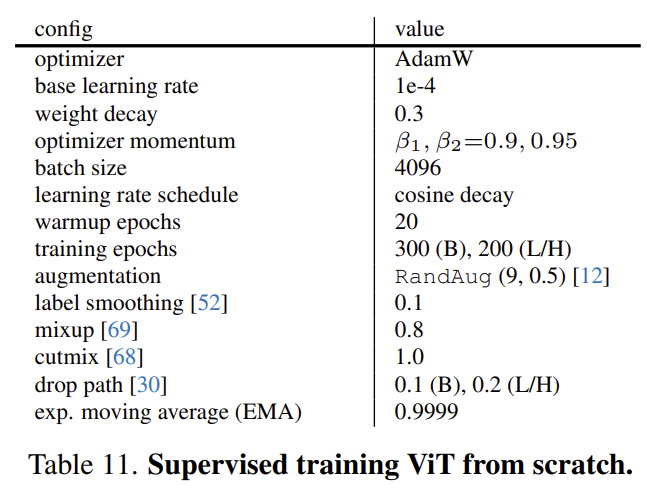

### We didn't use mixup and cutmix, RandAug like the original paper did.



## Classification - with Pre-Trained MAE Encoder

In [ ]:
import os
import math
import torch
import torchvision
from torchvision.transforms import Compose, ToTensor, RandomResizedCrop, Normalize
import csv  # Import CSV module

# Hyperparameters and constants
seed = 42
batch_size = 256
base_learning_rate = 1e-3
weight_decay = 0.05
warmup_epochs = 5
total_epochs = 100
layerwise_lr_decay = 0.75
num_classes = 10

# Paths
output_model_path = '/content/drive/My Drive/Colab_Models/vit-t-classifier.pt'
pretrained_model_path = '/content/drive/My Drive/Colab_Models/mae_pretrained_100.pth'
loss_data_path = '/content/drive/My Drive/Colab_Models/training_loss_data.csv'  # Path to save loss data

# Set random seed for reproducibility
set_seed(seed)

# Data augmentation and normalization for training
transform_train = Compose([
    RandomResizedCrop(32),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load datasets with appropriate transformations
train_dataset = torchvision.datasets.CIFAR10('data', train=True, download=True, transform=transform_train)
val_dataset = torchvision.datasets.CIFAR10('data', train=False, download=True, transform=transform_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Setup computation device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize model
if os.path.exists(pretrained_model_path):
    model = MAEModel().to(device)
    model.load_state_dict(torch.load(pretrained_model_path, map_location=device))
    print(f"Loaded pretrained model from {pretrained_model_path}")
else:
    model = MAEModel().to(device)
    print("Initialized model from scratch.")

model = ViT_Classifier(model.encoder, num_classes=num_classes).to(device)

# Define the loss function with label smoothing
class LabelSmoothingLoss(torch.nn.Module):
    def __init__(self, classes, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = -1

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

loss_fn = LabelSmoothingLoss(classes=num_classes)

# Optimizer setup with layer-wise learning rate decay
optimizer = torch.optim.AdamW(model.parameters(), lr=base_learning_rate, betas=(0.9, 0.999), weight_decay=weight_decay)

# Learning rate scheduler setup with warmup
def adjust_learning_rate(optimizer, epoch):
    if epoch < warmup_epochs:
        lr = base_lr * (epoch + 1) / warmup_epochs
    else:
        lr = base_lr * 0.5 * (1 + math.cos(math.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs)))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Prepare CSV file to save loss data
with open(loss_data_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy'])

# Training loop
best_val_acc = 0
for epoch in range(total_epochs):
    adjust_learning_rate(optimizer, epoch)
    model.train()
    train_losses, train_accs = [], []
    for img, label in train_dataloader:
        img, label = img.to(device), label.to(device)
        logits = model(img)
        loss = loss_fn(logits, label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_losses.append(loss.item())
        train_accs.append((logits.argmax(dim=-1) == label).float().mean().item())

    model.eval()
    val_losses, val_accs = [], []
    with torch.no_grad():
        for img, label in val_dataloader:
            img, label = img.to(device), label.to(device)
            logits = model(img)
            loss = loss_fn(logits, label)
            val_losses.append(loss.item())
            val_accs.append((logits.argmax(dim=-1) == label).float().mean().item())

    # Calculate average losses and accuracies
    avg_train_loss = sum(train_losses) / len(train_losses)
    avg_val_loss = sum(val_losses) / len(val_losses)
    avg_train_acc = sum(train_accs) / len(train_accs)
    avg_val_acc = sum(val_accs) / len(val_accs)

    # Log epoch results to CSV
    with open(loss_data_path, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch, avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc])

    print(f'Epoch {epoch}: Training Loss {avg_train_loss:.4f}, Accuracy {avg_train_acc:.4f}')
    print(f'Epoch {epoch}: Validation Loss {avg_val_loss:.4f}, Accuracy {avg_val_acc:.4f}')

    if avg_val_acc > best_val_acc:
        best_val_acc = avg_val_acc
        torch.save(model.state_dict(), output_model_path)
        print(f'Saved new best model with Accuracy {best_val_acc:.4f} at Epoch {epoch}')


Files already downloaded and verified
Files already downloaded and verified
Loaded pretrained model from /content/drive/My Drive/Colab_Models/mae_pretrained_100.pth
Epoch 0: Training Loss 1.9407, Accuracy 0.3196
Epoch 0: Validation Loss 1.8100, Accuracy 0.3919
Saved new best model with Accuracy 0.3919 at Epoch 0
Epoch 1: Training Loss 1.7296, Accuracy 0.4381
Epoch 1: Validation Loss 1.6374, Accuracy 0.4865
Saved new best model with Accuracy 0.4865 at Epoch 1
Epoch 2: Training Loss 1.6152, Accuracy 0.4984
Epoch 2: Validation Loss 1.5918, Accuracy 0.5101
Saved new best model with Accuracy 0.5101 at Epoch 2
Epoch 3: Training Loss 1.5340, Accuracy 0.5382
Epoch 3: Validation Loss 1.4885, Accuracy 0.5584
Saved new best model with Accuracy 0.5584 at Epoch 3
Epoch 4: Training Loss 1.4653, Accuracy 0.5723
Epoch 4: Validation Loss 1.4688, Accuracy 0.5728
Saved new best model with Accuracy 0.5728 at Epoch 4
Epoch 5: Training Loss 1.4153, Accuracy 0.5957
Epoch 5: Validation Loss 1.4093, Accuracy 0

## Classification - Baseline Model (Supervised Learning from scratch)

In [23]:
import os
import random
import math
import torch
import torchvision
from torchvision.transforms import Compose, ToTensor, RandomResizedCrop, Normalize
import csv  # Import CSV module

# Hyperparameters and constants
seed = 42
batch_size = 256
base_learning_rate = 1e-3
weight_decay = 0.05
warmup_epochs = 5
total_epochs = 100
layerwise_lr_decay = 0.75
num_classes = 10

# Paths
output_model_path = '/content/drive/My Drive/Colab_Models/baseline-classifier.pt'
loss_data_path = '/content/drive/My Drive/Colab_Models/baseline_training_loss_data.csv'  # Path to save loss data

# Set random seed for reproducibility
def set_seed(seed=42):
    """Set seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)

# Data augmentation and normalization for training
transform_train = Compose([
    RandomResizedCrop(32),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load datasets with appropriate transformations
train_dataset = torchvision.datasets.CIFAR10('data', train=True, download=True, transform=transform_train)
val_dataset = torchvision.datasets.CIFAR10('data', train=False, download=True, transform=transform_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Setup computation device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize model (Supervised Learning from scratch)

model = MAEModel().to(device)
print("Initialized model from scratch.")

model = ViT_Classifier(model.encoder, num_classes=num_classes).to(device)

# Define the loss function with label smoothing
class LabelSmoothingLoss(torch.nn.Module):
    def __init__(self, classes, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = -1

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

loss_fn = LabelSmoothingLoss(classes=num_classes)

# Optimizer setup with layer-wise learning rate decay
optimizer = torch.optim.AdamW(model.parameters(), lr=base_learning_rate, betas=(0.9, 0.999), weight_decay=weight_decay)

# Learning rate scheduler setup with warmup
def adjust_learning_rate(optimizer, epoch):
    if epoch < warmup_epochs:
        lr = base_lr * (epoch + 1) / warmup_epochs
    else:
        lr = base_lr * 0.5 * (1 + math.cos(math.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs)))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Prepare CSV file to save loss data
with open(loss_data_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy'])

# Training loop
best_val_acc = 0
for epoch in range(total_epochs):
    adjust_learning_rate(optimizer, epoch)
    model.train()
    train_losses, train_accs = [], []
    for img, label in train_dataloader:
        img, label = img.to(device), label.to(device)
        logits = model(img)
        loss = loss_fn(logits, label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_losses.append(loss.item())
        train_accs.append((logits.argmax(dim=-1) == label).float().mean().item())

    model.eval()
    val_losses, val_accs = [], []
    with torch.no_grad():
        for img, label in val_dataloader:
            img, label = img.to(device), label.to(device)
            logits = model(img)
            loss = loss_fn(logits, label)
            val_losses.append(loss.item())
            val_accs.append((logits.argmax(dim=-1) == label).float().mean().item())

    # Calculate average losses and accuracies
    avg_train_loss = sum(train_losses) / len(train_losses)
    avg_val_loss = sum(val_losses) / len(val_losses)
    avg_train_acc = sum(train_accs) / len(train_accs)
    avg_val_acc = sum(val_accs) / len(val_accs)

    # Log epoch results to CSV
    with open(loss_data_path, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch, avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc])

    print(f'Epoch {epoch}: Training Loss {avg_train_loss:.4f}, Accuracy {avg_train_acc:.4f}')
    print(f'Epoch {epoch}: Validation Loss {avg_val_loss:.4f}, Accuracy {avg_val_acc:.4f}')

    if avg_val_acc > best_val_acc:
        best_val_acc = avg_val_acc
        torch.save(model.state_dict(), output_model_path)
        print(f'Saved new best model with Accuracy {best_val_acc:.4f} at Epoch {epoch}')


Files already downloaded and verified
Files already downloaded and verified
Initialized model from scratch.
Epoch 0: Training Loss 2.0747, Accuracy 0.2436
Epoch 0: Validation Loss 1.9992, Accuracy 0.2883
Saved new best model with Accuracy 0.2883 at Epoch 0
Epoch 1: Training Loss 1.9603, Accuracy 0.3042
Epoch 1: Validation Loss 1.9094, Accuracy 0.3335
Saved new best model with Accuracy 0.3335 at Epoch 1
Epoch 2: Training Loss 1.8929, Accuracy 0.3471
Epoch 2: Validation Loss 1.8470, Accuracy 0.3744
Saved new best model with Accuracy 0.3744 at Epoch 2
Epoch 3: Training Loss 1.8399, Accuracy 0.3782
Epoch 3: Validation Loss 1.8152, Accuracy 0.4010
Saved new best model with Accuracy 0.4010 at Epoch 3
Epoch 4: Training Loss 1.7819, Accuracy 0.4092
Epoch 4: Validation Loss 1.7628, Accuracy 0.4250
Saved new best model with Accuracy 0.4250 at Epoch 4
Epoch 5: Training Loss 1.7373, Accuracy 0.4315
Epoch 5: Validation Loss 1.7351, Accuracy 0.4300
Saved new best model with Accuracy 0.4300 at Epoch 